In [1]:
mp_pdf = True
import django, sys, os
if mp_pdf:
    import matplotlib
    matplotlib.use('pgf')
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "xelatex",
        "figure.figsize": [12,7]
    }
    matplotlib.rcParams.update(pgf_with_latex)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle
%matplotlib notebook

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from scipy.sparse import coo_matrix, find
from sklearn.manifold import TSNE

from scoping.models import *
from tmv_app.models import *
import tmv_app.utils.plotting as tplots
from time import time
from matplotlib import patches

run_id = 665
s = 0
p = 200

dto = DocDynamicTopic.objects

In [132]:
class SquareCollection:
    def __init__(self):
        self.objects = []
        
    def add(self, o):
        self.objects.append(o)

    def get(self,**kwargs):
        matches = []
        for o in self.objects:
            match = True
            for k,v in kwargs.items():
                if getattr(o,k)!=v:
                    match=False
            if match:
                matches.append(o)
        if len(matches) > 0:
            return matches[0]
        else:
            return None
                
class CoordSquare:
    def __init__(self,x1,x2,y1,y2,r_ind,tsne_results,ar=None):
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.r_ind = r_ind
        self.tsne_results = tsne_results
        self.ar = ar
        self.size = self.r_ind.shape[0]
        self.share = None
    
    def get_points(self):
        r = self.tsne_results#[self.r_ind[:,0],:]
        conditions = (r[:,0]>self.x1) & (r[:,0]<self.x2) & (r[:,1]>self.y1) & (r[:,1]<self.y2)
        self.r = r[conditions]
        self.r_ind = self.r_ind[conditions]
        
        self.share = self.r.shape[0] / self.size
        
        return self.r.shape[0] / self.size
    def summarise_topics(self,run_id):
        stat = RunStats.objects.get(pk=run_id)
        docs = Doc.objects.filter(id__in=self.r_ind)
        if stat.method=="DT":
            dt_string = 'docdynamictopic'
        else:
            dt_string = 'doctopic'
        topics = docs.filter(
            **{f'{dt_string}__run_id': run_id}
        ).values(f'{dt_string}__topic__title').annotate(
            tscore=Sum(f'{dt_string}__score')
        ).order_by('-tscore')
        total = topics.aggregate(tsum = Sum('tscore'))
        df = pd.DataFrame.from_dict(list(topics))
        df['x1'] = self.x1
        df['x2'] = self.x2
        df['y1'] = self.y1
        df['y2'] = self.y2
        df['proportion'] = df['tscore'] / total['tsum']
        df = df[df['proportion']>0.001]
        return df

In [133]:
m = np.load('../tsne_results/data/run_{}_s_{}_m.npy'.format(run_id,s))
r_ind = np.load('../tsne_results/data/run_{}_s_{}_r_ind.npy'.format(run_id,s))
tsne_results = np.load('../tsne_results/data/run_{}_s_{}_p{}.npy'.format(run_id,s,p))

In [4]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
no_oecd_ids = r_ind
oecd_cats = list(Doc.objects.filter(id__in=r_ind).distinct('wc__oecd').values('wc__oecd'))
for i,c in enumerate(oecd_cats):
    c['docs'] = list(Doc.objects.filter(id__in=r_ind,wc__oecd=c['wc__oecd']).values_list('id',flat=True))
    c['name'] = c['wc__oecd']
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_oecd_ids = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]


<IPython.core.display.Javascript object>


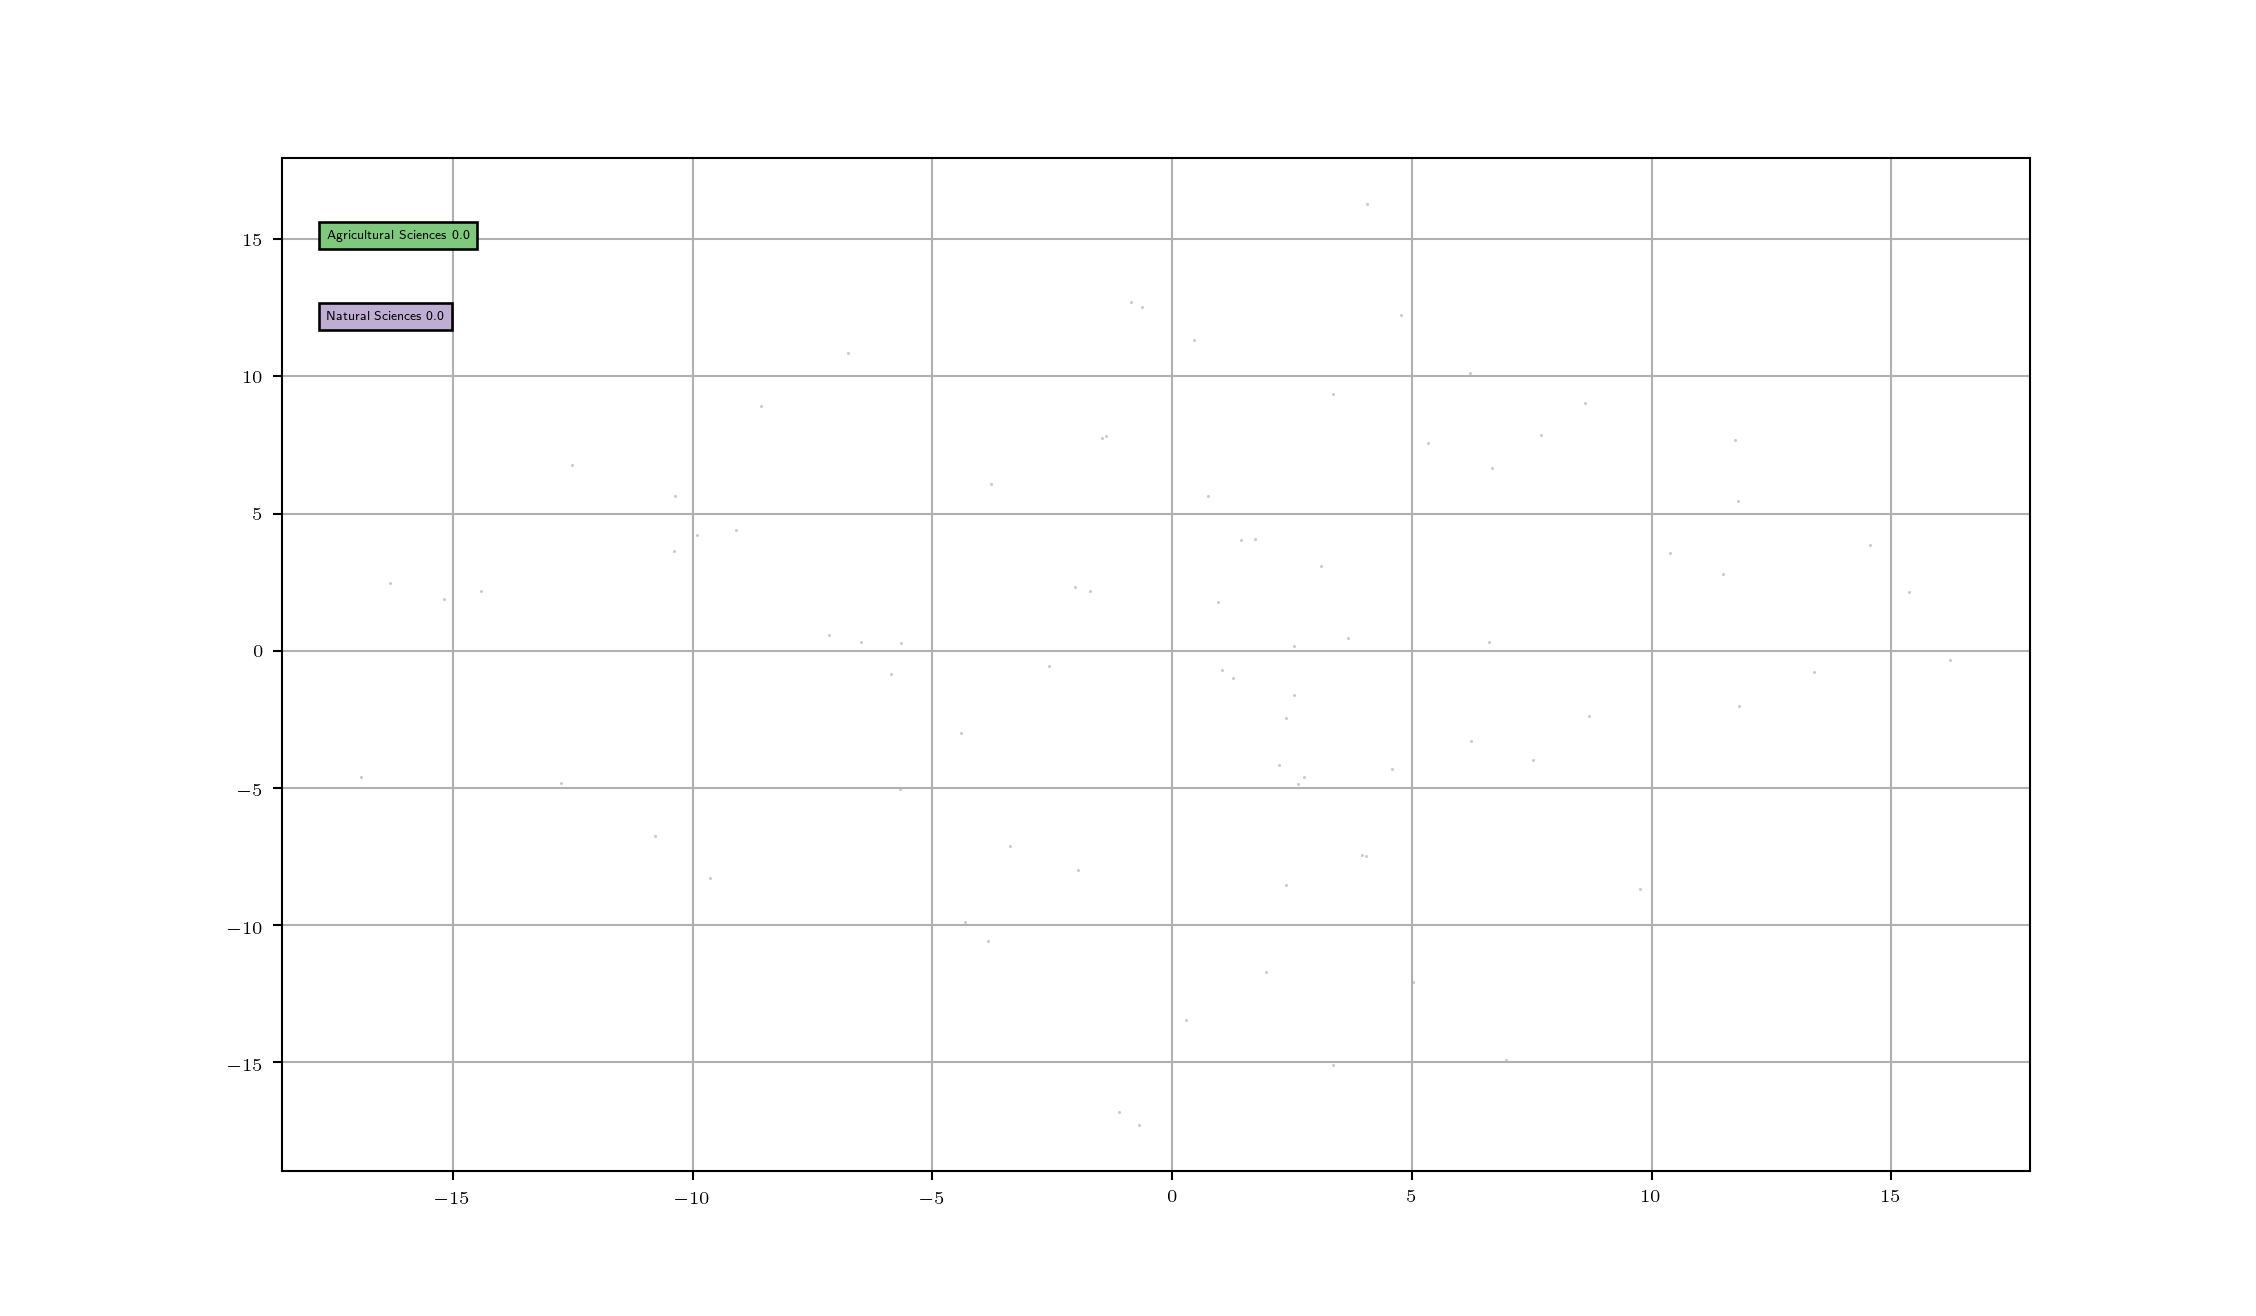

calculating points took 0.045s.
[-20. -15. -10.  -5.   0.   5.  10.  15.  20.]


In [134]:
import importlib
importlib.reload(tmv_app.utils.plotting)

tplots.plot_tsne(r_ind,tsne_results,oecd_cats,no_oecd_ids,verbose=True)
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_oecds.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_oecds.png'.format(run_id,s,p))

sc = SquareCollection()   
xs = plt.xticks()[0]
ys = plt.yticks()[0]

print(xs)

for i, x1 in enumerate(xs):
    if i==len(xs)-1:
        break
    x2 = xs[i+1]
    for j, y1 in enumerate(ys):
        if j==len(ys)-1:
            break
        y2 = ys[j+1]
        print(cs)

        cs = CoordSquare(x1,x2,y1,y2,r_ind,tsne_results,0)
        cs.get_points()
        sc.add(cs)
    
#plt.show()

In [137]:
df = None
for cs in sc.objects:
    if cs.share > 0:
        topics = cs.summarise_topics(run_id)
        if df is None:
            df = topics
        else:
            df = df.append(topics)
df.to_csv(f"../tables/tsne_topic_index_{run_id}.csv")

In [136]:
df

docdynamictopic__topic__title      tscore    x1    x2   y1    y2  \
0   {ozon, stratospher, tropospher}  169.152741 -20.0 -15.0 -5.0   0.0   
1      {increas, concentr, decreas}   13.280526 -20.0 -15.0 -5.0   0.0   
2           {climat, chang, impact}   12.686680 -20.0 -15.0 -5.0   0.0   
3            {emiss, reduct, reduc}   10.309311 -20.0 -15.0 -5.0   0.0   
4          {aerosol, cloud, radiat}    9.849981 -20.0 -15.0 -5.0   0.0   
5       {atmospher, surfac, observ}    8.903616 -20.0 -15.0 -5.0   0.0   
6        {trend, station, signific}    7.601754 -20.0 -15.0 -5.0   0.0   
7           {model, simul, predict}    7.342472 -20.0 -15.0 -5.0   0.0   
8           {temperatur, air, mean}    7.203397 -20.0 -15.0 -5.0   0.0   
9              {sst, pacif, atlant}    6.374167 -20.0 -15.0 -5.0   0.0   
10              {data, use, method}    6.111466 -20.0 -15.0 -5.0   0.0   
11         {scenario, futur, simul}    5.268205 -20.0 -15.0 -5.0   0.0   
12          {solar, radiat, irradi}    5.110767 -20.0 -15.0 -5.0   0.0   
13              {wind, speed, wave}    4.685644 -20.0 -15.0 -5.0   0.0   
14            {elev, ambient, leaf}    4.671736 -20.0 -15.0 -5.0   0.0   
15           {year, period, annual}    4.619378 -20.0 -15.0 -5.0   0.0   
16            {lake, level, diatom}    4.324145 -20.0 -15.0 -5.0   0.0   
17        {variabl, spatial, scale}    4.215189 -20.0 -15.0 -5.0   0.0   
18             {ice, sheet, arctic}    4.163118 -20.0 -15.0 -5.0   0.0   
19         {season, winter, summer}    3.832278 -20.0 -15.0 -5.0   0.0   
20          {warm, global, centuri}    3.767962 -20.0 -15.0 -5.0   0.0   
21            {region, area, local}    3.712854 -20.0 -15.0 -5.0   0.0   
22     {methan, oxid, methanotroph}    3.691286 -20.0 -15.0 -5.0   0.0   
23        {project, futur, ensembl}    3.613496 -20.0 -15.0 -5.0   0.0   
24         {water, resourc, suppli}    3.556999 -20.0 -15.0 -5.0   0.0   
25         {research, social, issu}    3.301770 -20.0 -15.0 -5.0   0.0   
26              {flux, measur, net}    3.086049 -20.0 -15.0 -5.0   0.0   
27         {gas, greenhous, hydrat}    3.060336 -20.0 -15.0 -5.0   0.0   
28    {fertil, nitrogen, treatment}    2.904208 -20.0 -15.0 -5.0   0.0   
29       {carbon, dioxid, sequestr}    2.773799 -20.0 -15.0 -5.0   0.0   
..                              ...         ...   ...   ...  ...   ...   
46         {rainfal, monsoon, rain}    0.059717  15.0  20.0  5.0  10.0   
47    {ecosystem, function, ecolog}    0.057274  15.0  20.0  5.0  10.0   
48         {vulner, assess, social}    0.056802  15.0  20.0  5.0  10.0   
49       {adsorpt, captur, process}    0.055960  15.0  20.0  5.0  10.0   
50         {power, electr, generat}    0.053237  15.0  20.0  5.0  10.0   
51         {glacier, mass, retreat}    0.052097  15.0  20.0  5.0  10.0   
52        {energi, renew, consumpt}    0.048827  15.0  20.0  5.0  10.0   
53            {fuel, fossil, engin}    0.045346  15.0  20.0  5.0  10.0   
54          {land, use, agricultur}    0.043320  15.0  20.0  5.0  10.0   
55           {ocean, marin, acidif}    0.042713  15.0  20.0  5.0  10.0   
56         {technolog, ccs, captur}    0.042471  15.0  20.0  5.0  10.0   
57       {build, construct, design}    0.041504  15.0  20.0  5.0  10.0   
58             {ice, sheet, arctic}    0.041475  15.0  20.0  5.0  10.0   
59       {trend, station, signific}    0.039894  15.0  20.0  5.0  10.0   
60            {snow, cover, winter}    0.039228  15.0  20.0  5.0  10.0   
61            {elev, ambient, leaf}    0.038941  15.0  20.0  5.0  10.0   
62        {crop, agricultur, irrig}    0.037914  15.0  20.0  5.0  10.0   
63             {veget, ndvi, cover}    0.037682  15.0  20.0  5.0  10.0   
64               {heat, wave, cool}    0.035741  15.0  20.0  5.0  10.0   
65            {polici, govern, tax}    0.034634  15.0  20.0  5.0  10.0   
66              {urban, citi, area}    0.033700  15.0  20.0  5.0  10.0   
67               {sea, level, rise}    0.032685  15.0  20.0  5.0  10.0   
68        

0.0

In [115]:
plt.xticks()[0]

array([-20., -10.,   0.,  10.,  20.])

In [6]:
colors=["#66c2a5","#fc8d62","#8da0cb"]

no_wg_ids = r_ind
wgs = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
for i,c in enumerate(wgs):
    c['docs'] = list(Doc.objects.filter(
        id__in=r_ind,ipccref__wg__wg=c['wg']
    ).values_list('id',flat=True))
    c['color'] = colors[i]
    c['name'] = "WG{}".format(c['wg'])
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_wg_ids = no_wg_ids[np.isin(no_wg_ids,c['docs'],invert=True)]
    


<IPython.core.display.Javascript object>


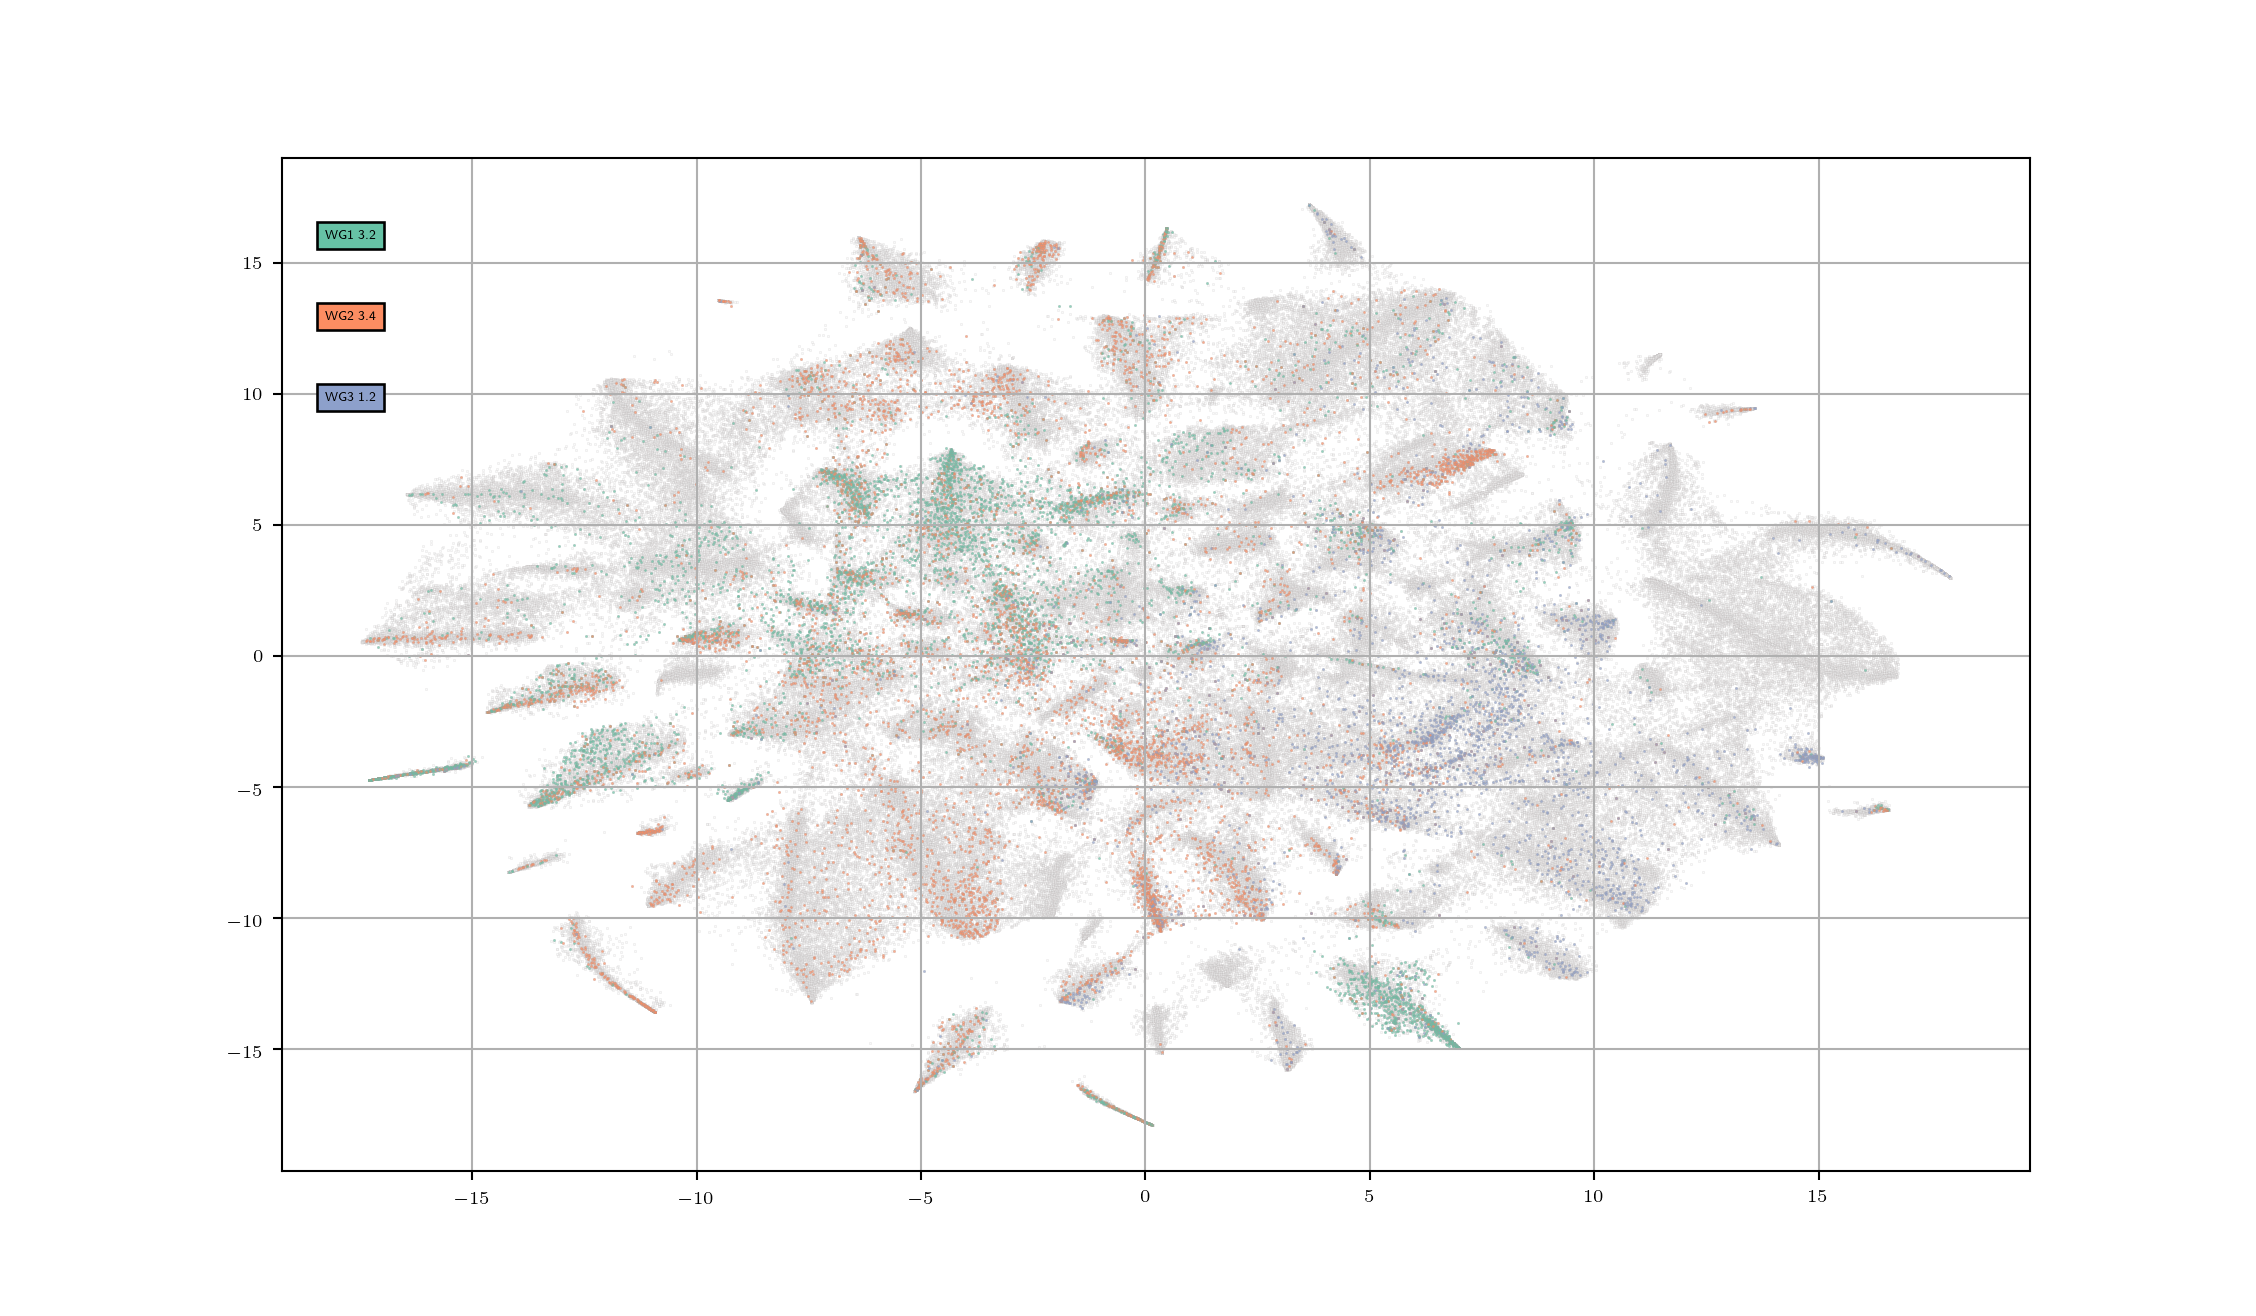

calculating points took 1.295s.


In [7]:
import importlib
importlib.reload(tmv_app.utils.plotting)

tmv_app.utils.plotting.plot_tsne(r_ind,tsne_results,wgs,no_wg_ids,verbose=True)

if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_wgs.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_wgs.png'.format(run_id,s,p))


plt.show()

<IPython.core.display.Javascript object>


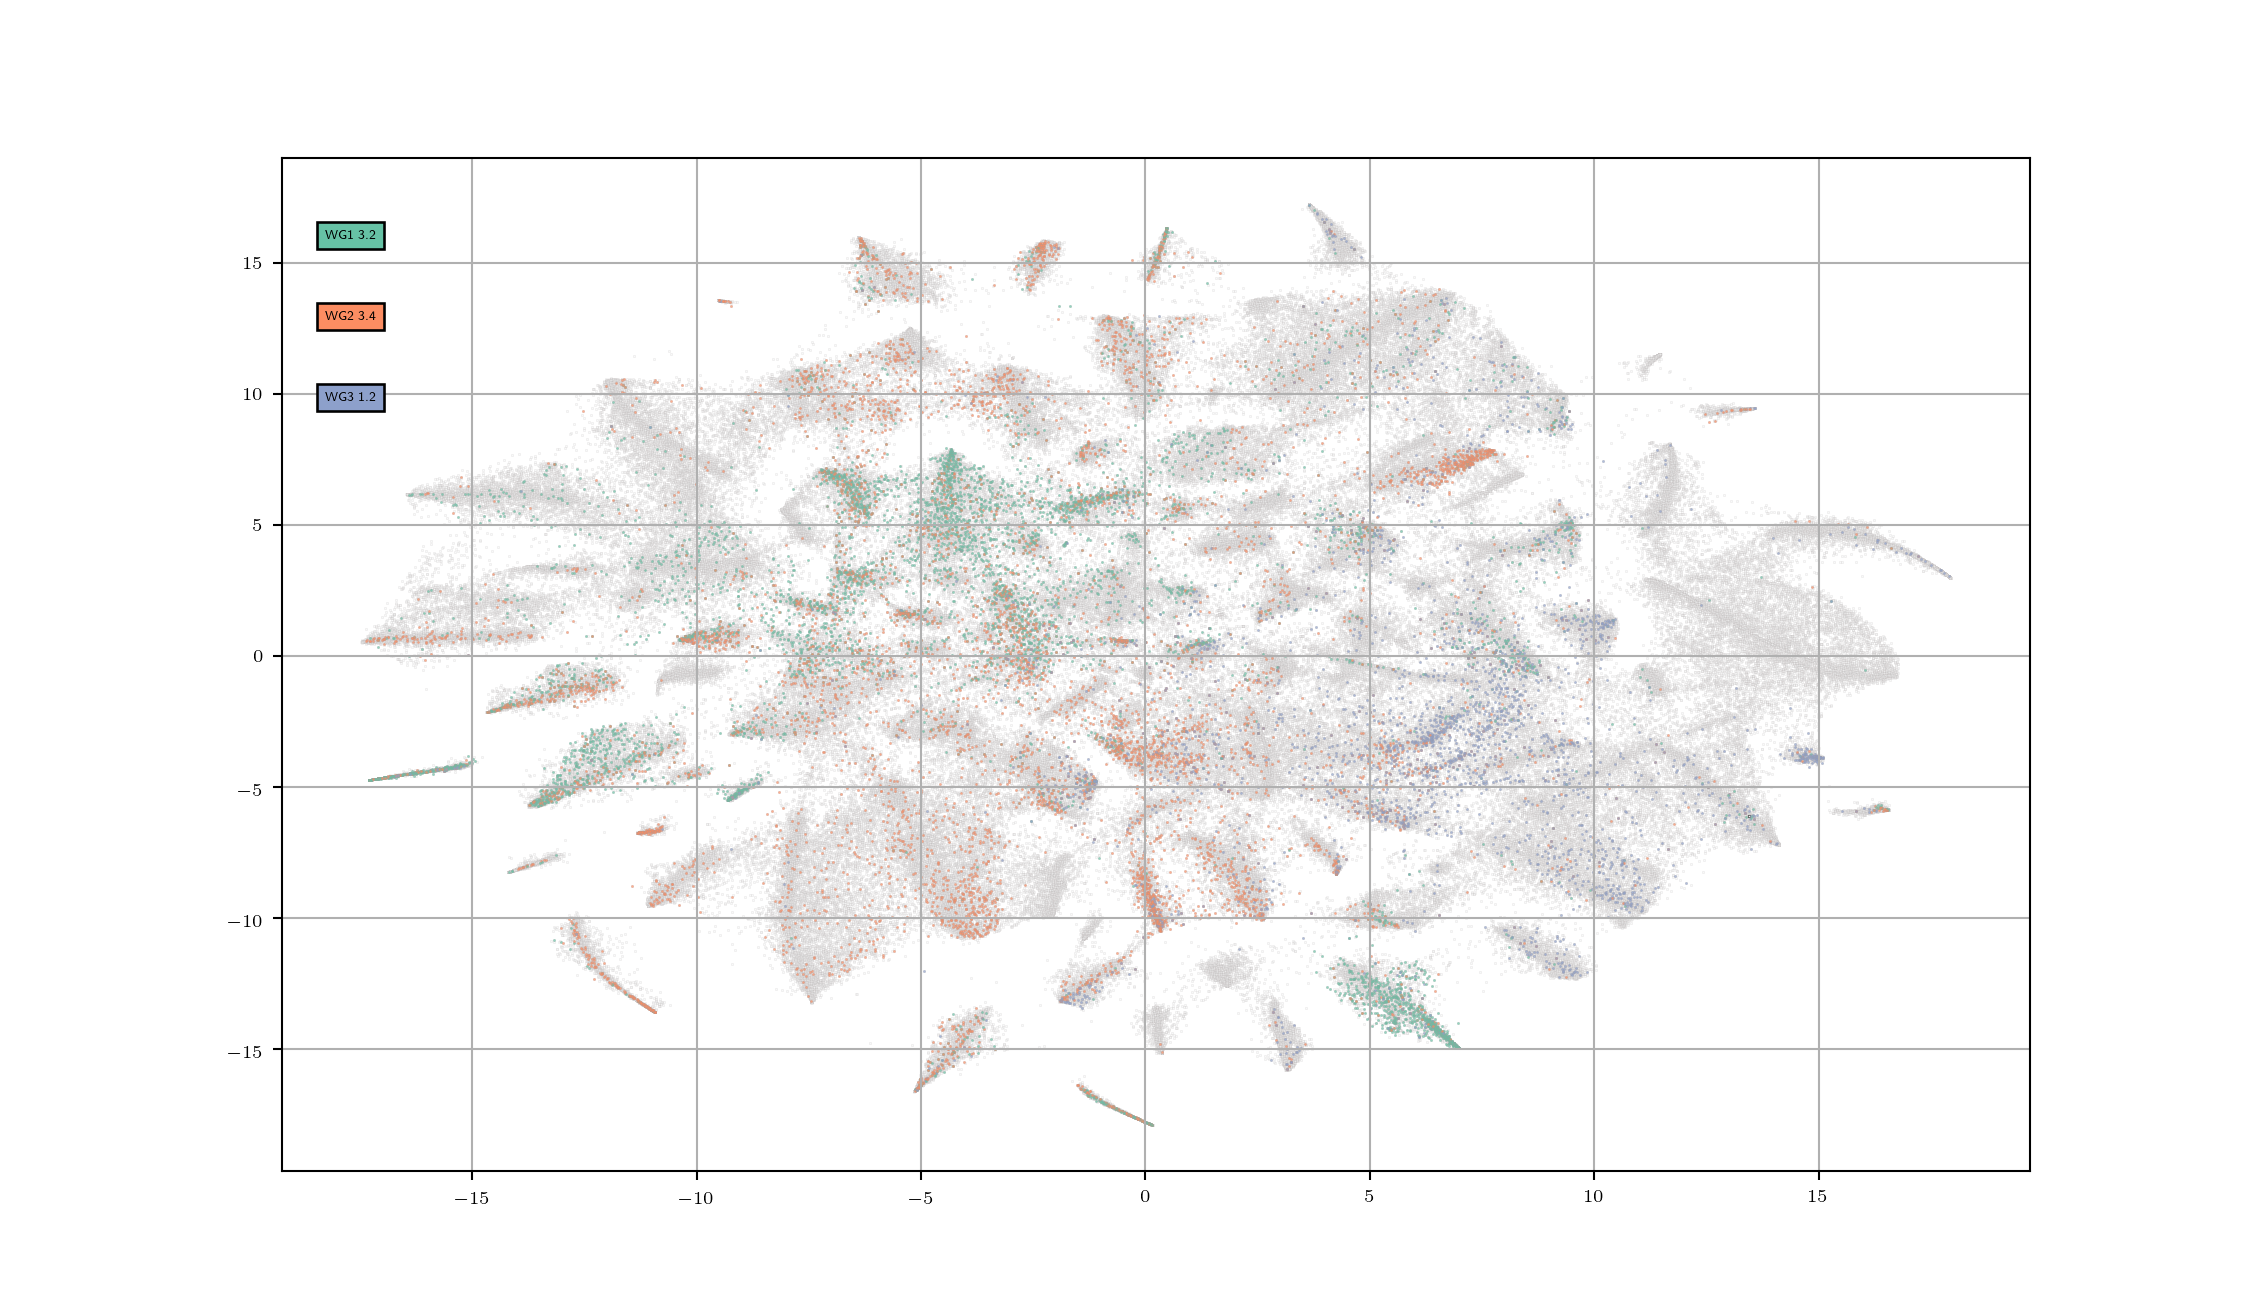

calculating points took 1.232s.


In [8]:
import importlib
importlib.reload(tmv_app.utils.plotting)

highlight_doc = np.argwhere(r_ind==69164)[0]

tmv_app.utils.plotting.plot_tsne(r_ind,tsne_results,wgs,no_wg_ids,verbose=True, hdoc=highlight_doc)

<IPython.core.display.Javascript object>


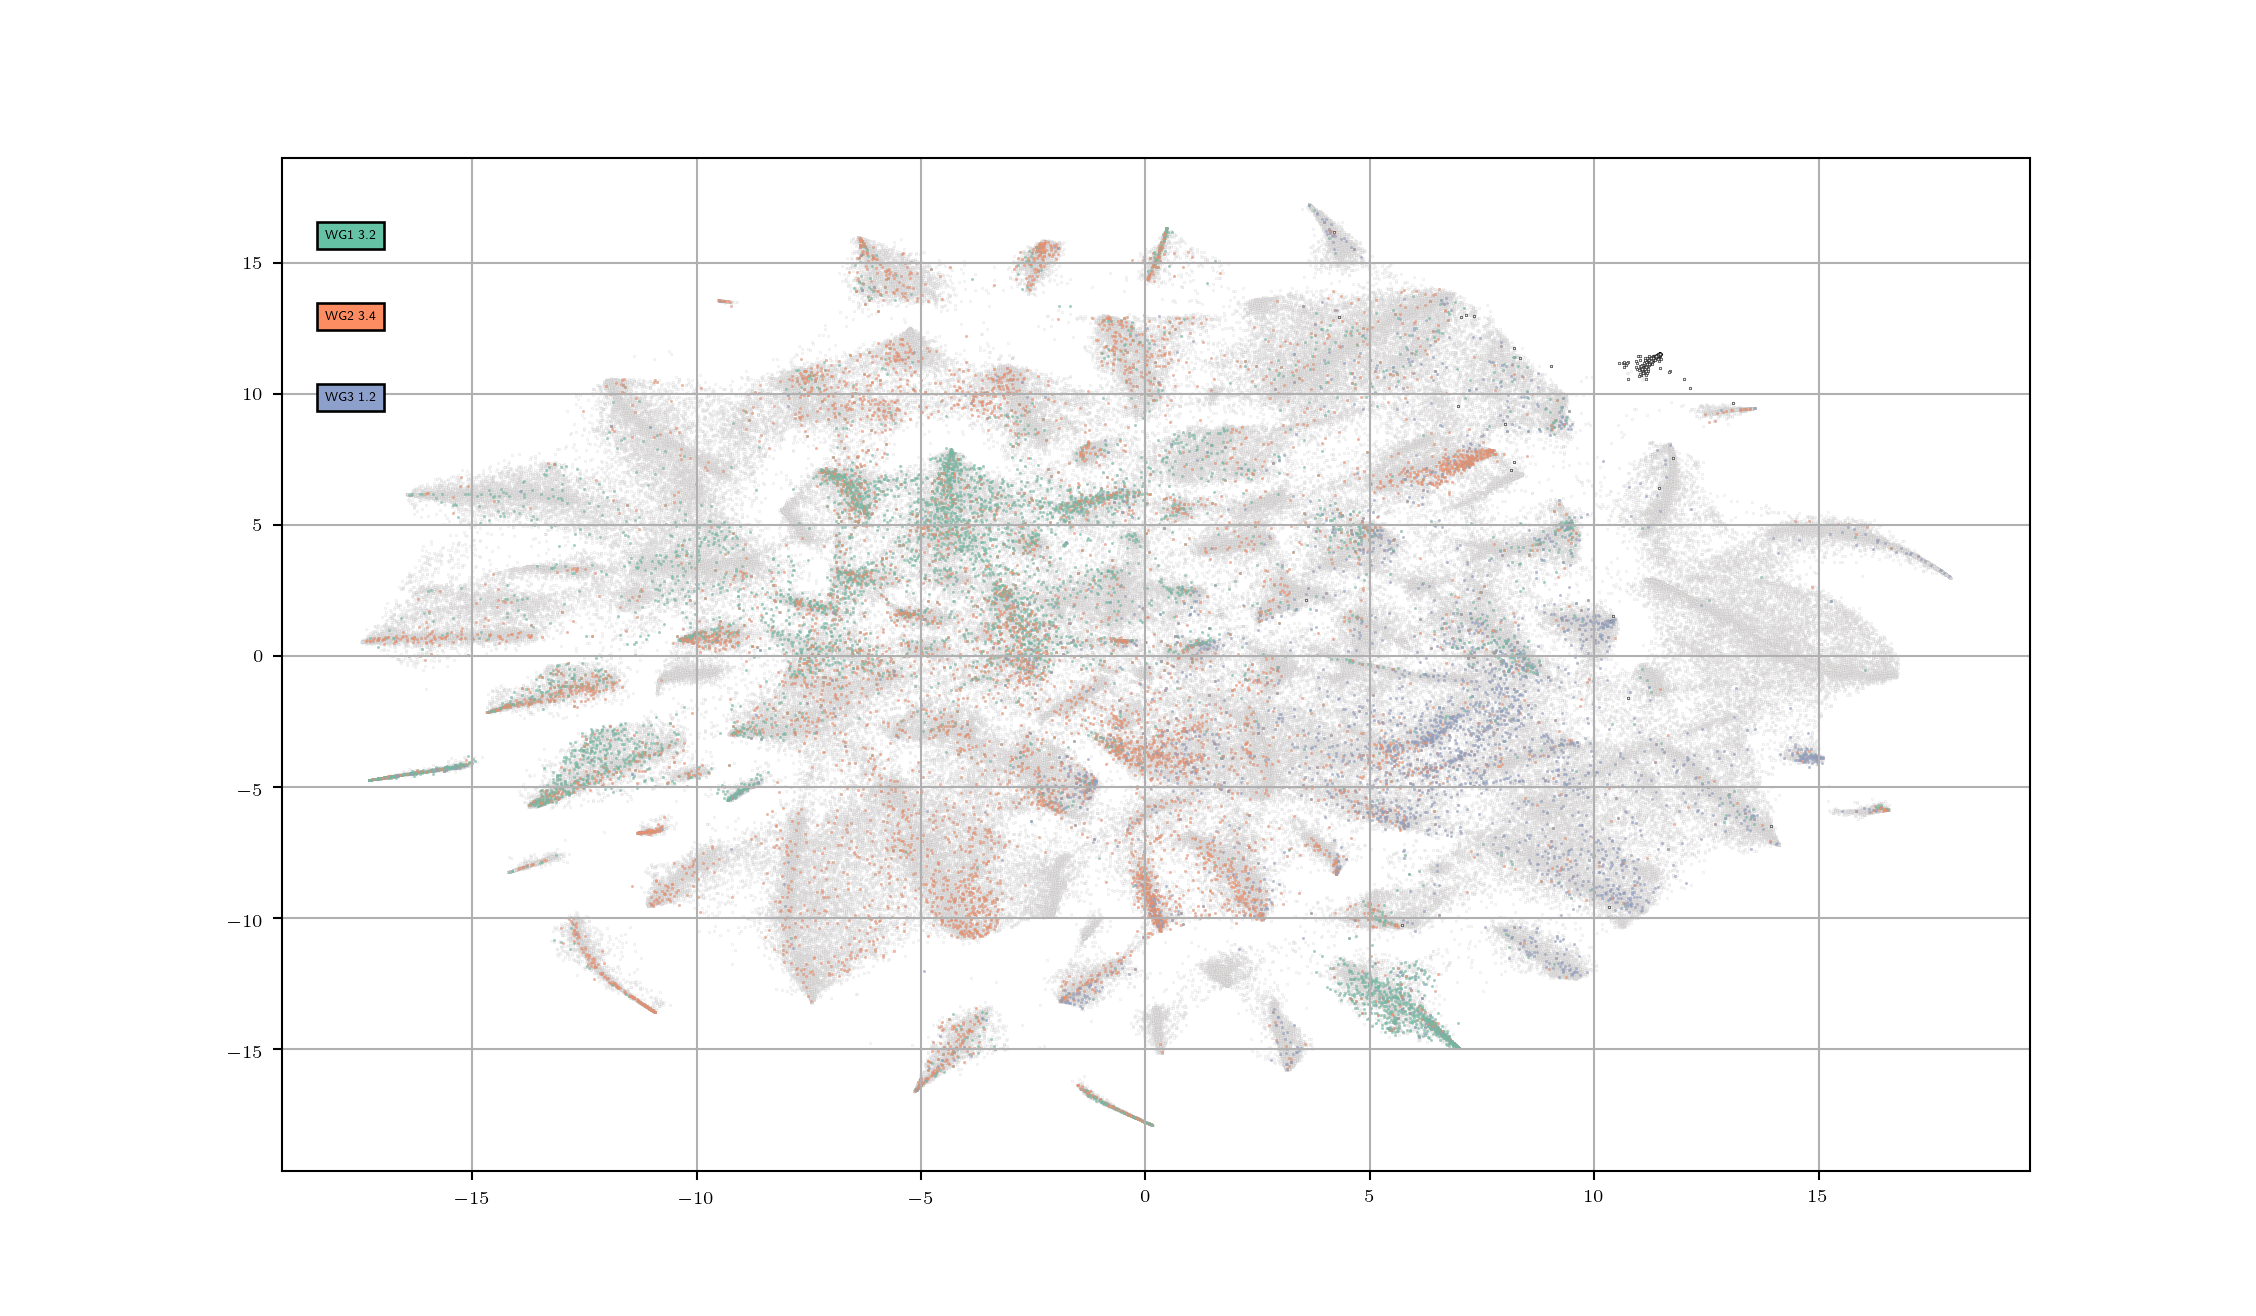

calculating points took 1.369s.


In [9]:
import importlib
importlib.reload(tmv_app.utils.plotting)

impacts = 11110
research = 11046
tech_ccs = 11026
biochar = 11020
aerosols = 11059

top = DynamicTopic.objects.get(pk=biochar)
tdocs = Doc.objects.filter(
    docdynamictopic__topic=top,
    docdynamictopic__score__gt=0.06
).order_by('-docdynamictopic__score').values_list('id',flat=True)

highlight_docs = np.argwhere(np.isin(r_ind,tdocs))

tmv_app.utils.plotting.plot_tsne(
    r_ind,tsne_results,wgs,
    no_wg_ids,verbose=True, hdoc=highlight_docs
)

<IPython.core.display.Javascript object>


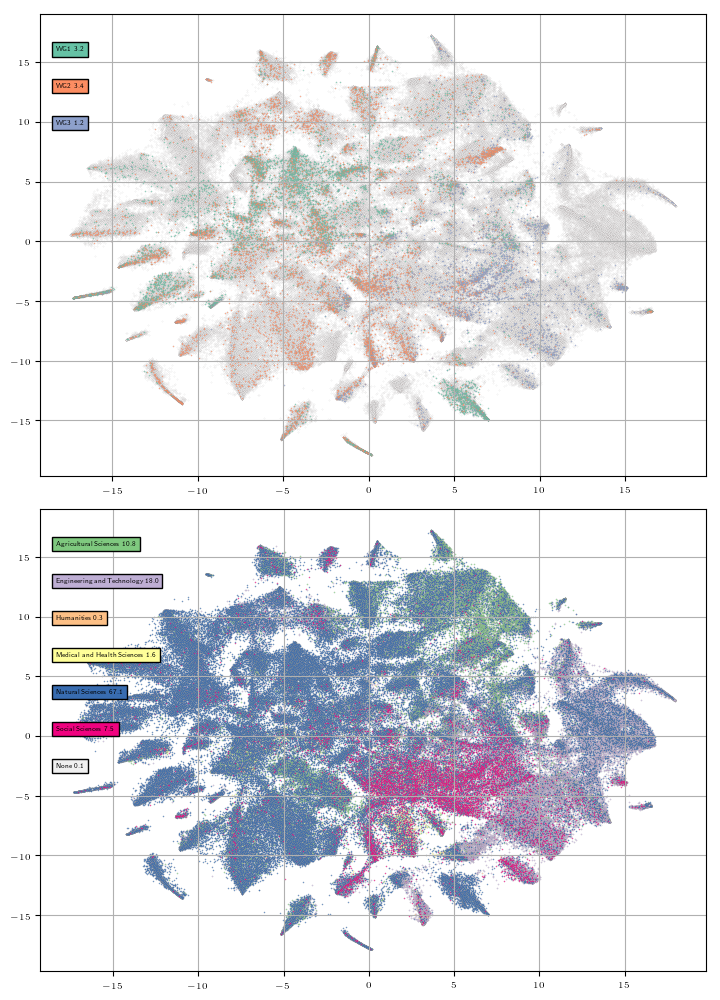

calculating points took 1.315s.
calculating points took 1.503s.


In [10]:
fig, axs = plt.subplots(2,1,figsize=(7.2,10))
tmv_app.utils.plotting.plot_tsne(
    r_ind,tsne_results,wgs,
    no_wg_ids,axs[0],verbose=True
)

tmv_app.utils.plotting.plot_tsne(
    r_ind,tsne_results,oecd_cats,
    no_oecd_ids,axs[1],verbose=True
)

fig.tight_layout()
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_double.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_double.png'.format(run_id,s,p))

plt.show()

In [11]:
xlim = axs[1].get_xlim()
ylim = axs[1].get_ylim()

<IPython.core.display.Javascript object>


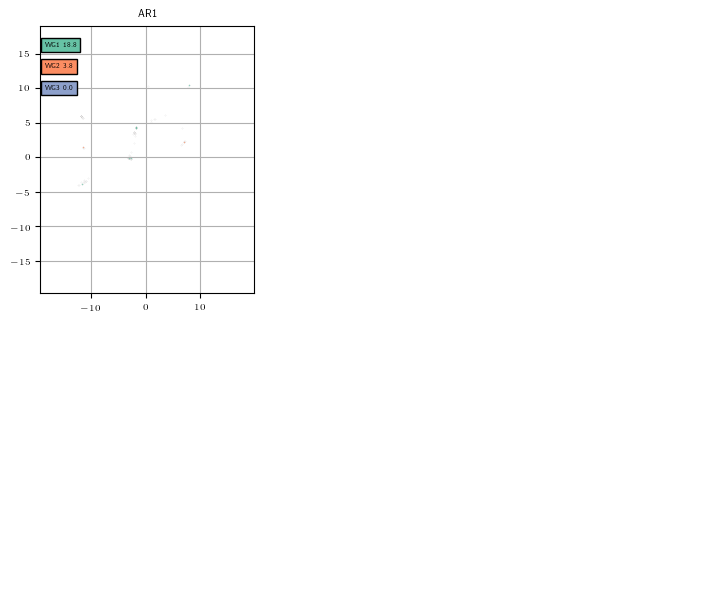

80
calculating points took 0.034s.


In [103]:

fig = plt.figure(figsize=(7.2,6))

sc = SquareCollection()   

for i,ar in enumerate(AR.objects.filter(ar__gt=0).order_by('ar')[:1]):
    ax = fig.add_subplot(2,3,i+1)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ys = range(ar.start,ar.end+1)
    ydocs = Doc.objects.filter(id__in=r_ind,PY__in=ys).values_list('pk',flat=True)  
    
    print(len(ydocs))
    
    doc_matches = np.argwhere(np.isin(r_ind,ydocs))[:,0]
    doc_ids = r_ind[doc_matches]
    results = tsne_results[doc_matches]

    
    colors=["#66c2a5","#fc8d62","#8da0cb"]

    no_wg_ids = doc_ids
    wgs = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
    for i,c in enumerate(wgs):
        c['docs'] = list(Doc.objects.filter(
            id__in=doc_ids,ipccref__wg__wg=c['wg']
        ).values_list('id',flat=True))
        c['color'] = colors[i]
        c['name'] = "WG{}".format(c['wg'])
        c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
        no_wg_ids = no_wg_ids[np.isin(no_wg_ids,c['docs'],invert=True)]
        
    colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
        
    no_oecd_ids = doc_ids
    oecd_cats = list(Doc.objects.filter(id__in=doc_ids).distinct('wc__oecd').values('wc__oecd'))
    for i,c in enumerate(oecd_cats):
        c['docs'] = list(Doc.objects.filter(id__in=doc_ids,wc__oecd=c['wc__oecd']).values_list('id',flat=True))
        c['name'] = c['wc__oecd']
        c['color'] = colors[i]
        c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
        no_oecd_ids = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]

    #tmv_app.utils.plotting.plot_tsne(
    #    doc_ids,results,oecd_cats,
    #    no_oecd_ids,ax,verbose=True,
    #    legend=False
    #)
    tmv_app.utils.plotting.plot_tsne(
        doc_ids,results,wgs,
        no_wg_ids,ax,verbose=True
    )
    ax.set_title(ar.name)
    
    xs = ax.get_xticks()
    ys = ax.get_yticks()
         

    for i, x1 in enumerate(xs):
        if i==len(xs)-1:
            break
        x2 = xs[i+1]
        for j, y1 in enumerate(ys):
            if j==len(ys)-1:
                break
            y2 = ys[j+1]

            cs = CoordSquare(x1,x2,y1,y2,doc_ids,results,ar.ar)
            cs.get_points()
            sc.add(cs)
            prev = sc.get(x1=x1,x2=x2,y1=y1,y2=y2,ar=ar.ar-1)
            
            if prev is not None:        
                if cs.share > prev.share:
                    col = "green"
                elif cs.share == prev.share:
                    col = "None"
                else:
                    col = "red"
                    
                if abs(cs.share-prev.share) > 0.01:
                    alpha = 0.2
                else:
                    alpha = 0.1

                # Create a Rectangle patch
                rect = patches.Rectangle(
                    (x1,y1),x2-x1,y2-y1,
                    linewidth=1,edgecolor='r',
                    facecolor=col,alpha=alpha
                )

                # Add the patch to the Axes
                ax.add_patch(rect)
                
            #ax.text(
            #    x2-(x2-x1)/2,y2-(y2-y1)/2,"bla",
            #    ha="center",
            #    va="center"
            #)



fig.tight_layout()
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_evolution.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_evolution.png'.format(run_id,s,p))
plt.show()

In [107]:
print(cs.tsne_results.shape)
cs.tsne_results

(80, 2)


array([[ -2.06198133,   3.47813954],
       [ -1.97316916,   3.46160388],
       [ -1.77788231,   4.35530549],
       [ -2.62264473,  -0.26696651],
       [ -3.0843253 ,  -0.0994416 ],
       [ -3.02435636,  -0.14715722],
       [ -1.77400863,   4.29536189],
       [ -2.71592842,   0.78675086],
       [ -2.07537674,   3.57268143],
       [  3.62472658,   6.03178825],
       [-11.83489933,   5.91864092],
       [-11.81327149,   5.90955597],
       [-11.07806662,  -3.54678507],
       [-11.75927422,   5.89449523],
       [ -3.07823011,  -0.10672218],
       [ -1.79233257,   4.2262087 ],
       [  0.9256313 ,   5.12998977],
       [  1.56972467,   5.51786532],
       [ -2.21664226,   3.30655534],
       [ -2.74426005,  -0.11962429],
       [-10.83190846,  -3.49446486],
       [-11.70419281,  -3.67331187],
       [  7.02394012,   2.2139952 ],
       [ -3.1044525 ,  -0.08530755],
       [ -1.96871795,   3.07987431],
       [-11.20494803,  -3.6381068 ],
       [ -2.02844726,   3.68060562],
 

In [85]:
x1=-10
x2=0
y1=-15
y2=-10
cs = sc.get(x1=x1,x2=x2,y1=y1,y2=y2,ar=5)
cs = CoordSquare(x1,x2,y1,y2,cs.r_ind,cs.tsne_results,cs.ar)
cs.get_points()
topics = cs.summarise_topics(665)
topics.head()


docdynamictopic__topic__title      tscore  x1  x2  y1  y2  proportion
0        {popul, genet, divers}  133.684733 -10   0 -15 -10    0.177607
1           {urban, citi, area}   77.566034 -10   0 -15 -10    0.103050
2      {speci, distribut, rang}   67.683939 -10   0 -15 -10    0.089921
3         {fire, burn, wildfir}   37.914143 -10   0 -15 -10    0.050371
4       {climat, chang, impact}   34.583308 -10   0 -15 -10    0.045946

In [81]:
topics.head()

docdynamictopic__topic__title      tscore  proportion
0        {popul, genet, divers}  133.684733    0.177607
1           {urban, citi, area}   77.566034    0.103050
2      {speci, distribut, rang}   67.683939    0.089921
3         {fire, burn, wildfir}   37.914143    0.050371
4       {climat, chang, impact}   34.583308    0.045946

In [39]:
cs.r_ind
self = cs
r = self.tsne_results
print(r.shape)
conditions = (r[:,0]>self.x1) & (r[:,0]<self.x2) & (r[:,1]>self.y1) & (r[:,1]<self.y2)
r[conditions].shape

(110104, 2)


(3322, 2)

In [14]:
docs.values('docdynamictopic__topic__title').annotate(
    s = Sum('docdynamictopic__score')
).order_by('-s')

<QuerySet [{'docdynamictopic__topic__title': None, 's': 389.673827516725}, {'docdynamictopic__topic__title': '{elev, ambient, leaf}', 's': 263.078514690118}, {'docdynamictopic__topic__title': '{plant, seed, power}', 's': 45.6463662906045}, {'docdynamictopic__topic__title': '{plant, leaf, flower}', 's': 40.7126356149218}, {'docdynamictopic__topic__title': '{increas, concentr, decreas}', 's': 30.942145003265}, {'docdynamictopic__topic__title': '{root, respir, fine}', 's': 30.7497487387251}, {'docdynamictopic__topic__title': '{soil, moistur, microbi}', 's': 29.3216041188361}, {'docdynamictopic__topic__title': '{speci, distribut, rang}', 's': 28.4945374277478}, {'docdynamictopic__topic__title': '{fertil, nitrogen, treatment}', 's': 27.848501176912}, {'docdynamictopic__topic__title': '{concentr, atmospher, air}', 's': 24.3208823269833}, {'docdynamictopic__topic__title': '{growth, econom, radial}', 's': 23.8962722617508}, {'docdynamictopic__topic__title': '{tree, stand, pine}', 's': 22.84952

In [15]:
docs.values('kw__text').annotate(
    n = Count('pk')
).order_by('-n')

<QuerySet [{'kw__text': 'elevated co2', 'n': 1005}, {'kw__text': 'growth', 'n': 642}, {'kw__text': 'photosynthesis', 'n': 635}, {'kw__text': 'atmospheric co2', 'n': 572}, {'kw__text': 'carbon-dioxide', 'n': 527}, {'kw__text': 'climate change', 'n': 445}, {'kw__text': 'responses', 'n': 392}, {'kw__text': 'nitrogen', 'n': 384}, {'kw__text': 'enrichment', 'n': 365}, {'kw__text': 'carbon dioxide', 'n': 352}, {'kw__text': 'temperature', 'n': 335}, {'kw__text': 'plants', 'n': 289}, {'kw__text': 'global change', 'n': 250}, {'kw__text': 'gas-exchange', 'n': 247}, {'kw__text': 'co2', 'n': 234}, {'kw__text': 'face', 'n': 213}, {'kw__text': 'stomatal conductance', 'n': 194}, {'kw__text': 'acclimation', 'n': 194}, {'kw__text': 'climate-change', 'n': 190}, {'kw__text': 'co2 enrichment', 'n': 187}, '...(remaining elements truncated)...']>

In [16]:
class SquareCollection:
    def __init__(self):
        self.objects = []
        
    def add(self, o):
        self.objects.append(o)

    def get(self,**kwargs):
        matches = []
        for o in self.objects:
            match = True
            for k,v in kwargs.items():
                if getattr(o,k)!=v:
                    match=False
            if match:
                matches.append(o)
        if len(matches) > 0:
            return matches[0]
        else:
            return None
                
class CoordSquare:
    def __init__(self,x1,x2,y1,y2,r_ind,tsne_results,ar=None):
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.r_ind = r_ind
        self.tsne_results = tsne_results
        self.ar = ar
        self.size = self.r_ind.shape[0]
        self.share = None
    
    def get_points(self):
        r = self.tsne_results#[self.r_ind[:,0],:]
        conditions = (r[:,0]>self.x1) & (r[:,0]<self.x2) & (r[:,1]>self.y1) & (r[:,1]<self.y2)
        self.r = r[conditions]
        
        self.share = self.r.shape[0] / self.size
        
        return self.r.shape[0] / self.size
    
sc = SquareCollection()        

for i, x1 in enumerate(xs):
    if i==len(xs)-1:
        break
    x2 = xs[i+1]
    for j, y1 in enumerate(ys):
        if j==len(ys-1):
            break
        y2 = ys[i+1]
        
        cs = CoordSquare(x1,x2,y1,y2,doc_ids,tsne_results)
        sc.add(cs)
        
        
        
    if x1 > 5 and y1 > 5:
        break
        
        

In [17]:
sc.get(x1=x1,x2=x2,y1=y1,y2=y2)

In [18]:
d = {'x': 5,'y':2}
for key, value in d.items():
    print(key)
    print(value)

x
5
y
2


## Report topic composition of each square..... give in SM

##  furthest and closest points



def square_distance(x,y): return sum([(xi-yi)**2 for xi, yi in zip(x,y)])    

square_distance(tsne_results[0],tsne_results[1])
ma = 0
mi = 100
for i in range(len(tsne_results)):
    for j in range(len(tsne_results)):
        if i != j:
            d = square_distance(tsne_results[i],tsne_results[j])
            if d < mi:
                mi = d
                p1mi = i
                p2mi = j
            if d > ma:
                ma = d
                p1ma = i
                p1mi = j
        

from scipy.spatial import cKDTree
from scipy.spatial.distance import pdist, squareform
import timeit

Y = pdist(tsne_results[:10000])

Y.shape

m = squareform(Y)

m.shape

outside_points = tsne_results[(abs(tsne_results[:,0])>10) & (abs(tsne_results[:,1])>10)]

Y = pdist(outside_points)

m = squareform(Y)

m[2167,2168]